<a href="https://colab.research.google.com/github/AvinandanPatel/United-Airlines-Hackathon/blob/main/United_Airlines_Data_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MODELLING

In [28]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from scipy.sparse import hstack

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

import kaleido
import plotly.express as px
# Ensuring that plotly plots are visible in GitHub by saving them as static images.
import plotly.io as pio
pio.renderers.default = 'png'

# Remove warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Calling datasets
calls = pd.read_csv("/content/drive/MyDrive/Colab Datasets/United Airlines Dataset/calls.csv")
customers = pd.read_csv("/content/drive/MyDrive/Colab Datasets/United Airlines Dataset/customers.csv")
reason = pd.read_csv("/content/drive/MyDrive/Colab Datasets/United Airlines Dataset/reason.csv")
sent_stat = pd.read_csv("/content/drive/MyDrive/Colab Datasets/United Airlines Dataset/sentiment_statistics.csv")
test = pd.read_csv("/content/drive/MyDrive/Colab Datasets/United Airlines Dataset/test.csv")

# 1. PREPARING TRAINING DATA SET

In [4]:
# PREPARATION OF TRAINING DATASET
# Merging calls & reason dataset on the basis of call_id
result_inner = pd.merge(calls, reason, on='call_id', how='inner')

# Merging sentiment statistic on the basis of call_id
result = pd.merge(result_inner, sent_stat, on = 'call_id', how = 'inner')
result = result.drop('agent_id_y', axis=1)
result.rename(columns={'agent_id_x': 'agent_id'}, inplace=True)

# Merging customer data and finalize our data set
final_result = pd.merge(result, customers, on = 'customer_id', how = 'inner')

In [5]:
# DATA CLEANING - 1
# HANDLING MISSING VALUES

# Filling the NAN values to 0 of elite_level of customer
final_result['elite_level_code'].fillna(0, inplace = True)

# Handling missing values in agent_tone (categorical)
# Impute missing values with a new category "Unknown"
final_result['agent_tone'].fillna('Unknown', inplace=True)

# Handling missing values in average_sentiment (numerical)
# Impute missing values with the median
final_result['average_sentiment'].fillna(final_result['average_sentiment'].median(), inplace=True)

final_result.shape

(66653, 14)

In [6]:
# DATA CLEANING -2
# CLEANING OF UNIQUE VALUES OF TARGET FEATURE
print("UNIQUE CATEGORIES OF TARGET VARIABLE BEFORE CLEANING")
print(final_result["primary_call_reason"].unique())

# Replacing & to and in between words
final_result["primary_call_reason"] = final_result["primary_call_reason"].str.replace('&', 'and', regex=True)

# Replacing leading, trailing spaces, extra spaces and hyphens between words to single space
# regex = front space(^\s+), space inbetween(\s+), space at end(\s+$), hypens([-]+)
# Used Str.strip because to remove the trailing and front spaces
final_result["primary_call_reason"] = final_result["primary_call_reason"].str.replace(r'^\s+|\s+$|[-]+|\s+', ' ', regex=True).str.strip()

print("-"*100)
print("UNIQUE CATEGORIES OF TARGET VARIABLE AFTER CLEANING")
print(final_result["primary_call_reason"].unique())

UNIQUE CATEGORIES OF TARGET VARIABLE BEFORE CLEANING
['Voluntary  Cancel' 'Booking' 'IRROPS' 'Upgrade' 'Seating'
 'Mileage   Plus' 'Checkout' 'Voluntary   Change' 'Post Flight' 'Check In'
 'Other  Topics' 'Communications' 'Schedule Change' 'Products & Services'
 'IRROPS  ' 'Digital   Support' 'Seating  ' 'Disability'
 'Unaccompanied Minor' ' Baggage' 'Traveler  Updates' 'Communications  '
 'ETC' 'Upgrade  ' 'Unaccompanied Minor  ' 'Voluntary Change'
 'Voluntary Change  ' 'Checkout  ' 'Mileage Plus' 'Mileage Plus  '
 'Booking  ' 'Baggage  ' 'Post-Flight' 'Post-Flight  ' 'Schedule Change  '
 'Baggage' 'Traveler Updates' 'Voluntary Cancel' 'Check-In'
 'Products and Services' 'Check-In  ' 'Other Topics' 'Other Topics  '
 'ETC  ' 'Disability  ' 'Digital Support' 'Digital Support  '
 'Voluntary Cancel  ' 'Products and Services  ' 'Traveler Updates  '
 'Traveler   Updates' 'Digital  Support' 'Mileage  Plus'
 'Voluntary  Change']
----------------------------------------------------------------

In [7]:
# FEATURE ENGINEERING - 1
# CREATING AHT & AST & TOTAL CALL DURATION

# Conversion to datetime datatypes
final_result["call_start_datetime"] = pd.to_datetime(final_result["call_start_datetime"])
final_result["agent_assigned_datetime"] = pd.to_datetime(final_result["agent_assigned_datetime"])
final_result["call_end_datetime"] = pd.to_datetime(final_result["call_end_datetime"])

# Metric
# Speed to answer
final_result["Speed"] = final_result["agent_assigned_datetime"]-final_result["call_start_datetime"]
# Handling time
final_result["Handle"] = final_result["call_end_datetime"]-final_result["agent_assigned_datetime"]
# Total Call Duration
final_result["Total Call Duration"] = final_result["call_end_datetime"]-final_result["call_start_datetime"]

# Use seconds as measure
final_result["Speed_seconds"] = final_result["Speed"].dt.total_seconds()
final_result["Handle_seconds"] = final_result["Handle"].dt.total_seconds()

# Using minutes as measure
final_result["Speed_minutes"] = final_result["Speed"].dt.total_seconds() / 60
final_result["Handle_minutes"] = final_result["Handle"].dt.total_seconds() / 60
final_result["Total Call Duration"] = final_result["Total Call Duration"].dt.total_seconds() / 60

final_result.head(3)

,call_id,customer_id,agent_id,call_start_datetime,agent_assigned_datetime,call_end_datetime,call_transcript,primary_call_reason,agent_tone,customer_tone,...,silence_percent_average,customer_name,elite_level_code,Speed,Handle,Total Call Duration,Speed_seconds,Handle_seconds,Speed_minutes,Handle_minutes
0,4667960400,2033123310,963118,2024-07-31 23:56:00,2024-08-01 00:03:00,2024-08-01 00:34:00,\n\nAgent: Thank you for calling United Airlin...,Voluntary Cancel,neutral,angry,...,0.39,Matthew Foster,4.0,0 days 00:07:00,0 days 00:31:00,38.0,420.0,1860.0,7.0,31.0
1,1122072124,8186702651,519057,2024-08-01 00:03:00,2024-08-01 00:06:00,2024-08-01 00:18:00,\n\nAgent: Thank you for calling United Airlin...,Booking,calm,neutral,...,0.35,Tammy Walters,0.0,0 days 00:03:00,0 days 00:12:00,15.0,180.0,720.0,3.0,12.0
2,6834291559,2416856629,158319,2024-07-31 23:59:00,2024-08-01 00:07:00,2024-08-01 00:26:00,\n\nAgent: Thank you for calling United Airlin...,IRROPS,neutral,polite,...,0.32,Jeffery Dixon,0.0,0 days 00:08:00,0 days 00:19:00,27.0,480.0,1140.0,8.0,19.0


In [8]:
# FEATURE ENGINEERING - 2
# CONVERTING CALL TRANSCRIPT INTO MACHINE READBLE DATA USING NLP, TF-IDF PROCESSING.

# Package Calling
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Reduce the size of the transcripts by truncating & Proceed with TF-IDF processing.
# Limit the size of call transcripts to reduce memory consumption (e.g., first 500 characters of each transcript)
final_result['call_transcript'] = final_result['call_transcript'].str.slice(0, 500)

# Re-split the data after truncation
X_text = final_result['call_transcript']
Y = final_result['primary_call_reason']

# Apply TF-IDF Vectorization to the text data (to convert text into numeric features)
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X_tfidf = tfidf_vectorizer.fit_transform(X_text)

# Conver the sparse matrix to DataFrame
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=[f'tfidf_{i}' for i in range(X_tfidf.shape[1])])

In [9]:
# MAKING FINAL DATASET IN WHICH, WILL PERFORM MODELLING
# DEFINING OUR NUMERICAL & CATEGORICAL FEATURES , RESPONSE VARIABLE(CATEGORY)
features = [ 'elite_level_code', 'Handle_minutes', 'Speed_minutes',  'Total Call Duration' ,'silence_percent_average', 'average_sentiment','agent_tone',  'customer_tone']
response = 'primary_call_reason'

# SLICING DATASET BASED ON FEATURES & RESPONSE
X = final_result[features]
# COMBINING THE 'TFIDF FEATURES' i.e., tfidf_df with X
X = pd.concat([X.reset_index(drop=True), tfidf_df.reset_index(drop=True)], axis=1)

# TARGETVARIABLE
Y = final_result[response]

X.head(3)

,elite_level_code,Handle_minutes,Speed_minutes,Total Call Duration,silence_percent_average,average_sentiment,agent_tone,customer_tone,tfidf_0,tfidf_1,...,tfidf_990,tfidf_991,tfidf_992,tfidf_993,tfidf_994,tfidf_995,tfidf_996,tfidf_997,tfidf_998,tfidf_999
0,4.0,31.0,7.0,38.0,0.39,-0.04,neutral,angry,0.0,0.0,...,0.0,0.0,0.0,0.084848,0.0,0.0,0.0,0.0,0.139202,0.0
1,0.0,12.0,3.0,15.0,0.35,0.02,calm,neutral,0.0,0.0,...,0.0,0.0,0.0,0.090416,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,19.0,8.0,27.0,0.32,-0.13,neutral,polite,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0


In [10]:
# ENCODING THE CATEGORICAL FEATURES
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# EXTRACT CATEGORICAL FEATURES
categorical_feature = [feature for feature in X.columns if X[feature].dtypes == 'object']

# MAPPING THE FEATURES
for feature in categorical_feature:
    X[feature] = le.fit_transform(X[feature])
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print(le_name_mapping)

{'Unknown': 0, 'angry': 1, 'calm': 2, 'frustrated': 3, 'neutral': 4, 'polite': 5}
{'angry': 0, 'calm': 1, 'frustrated': 2, 'neutral': 3, 'polite': 4}


In [11]:
# SPLITTING INTO TRAINING & VALIDATION SET
# Step 3: Split the data into training and testing sets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)


# MODELLING
# LOGISTIC MODEL
logreg_model = LogisticRegression(max_iter=200)
# Train the model
logreg_model.fit(X_train, Y_train)
# Evaluate the model on the Validation set
Y_pred = logreg_model.predict(X_val)
# Print accuracy and classification report
print("Logistic Regression Accuracy:", accuracy_score(Y_val, Y_pred))
#print("Logistic Regression Classification Report:\n", classification_report(Y_val, Y_pred))



# RANDOM FOREST
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
# Train RandomForest model
rf_model.fit(X_train, Y_train)
# Evaluate RandomForest model
Y_pred_rf = rf_model.predict(X_val)
# Print accuracy and classification report for RandomForest
print("RandomForest Accuracy:", accuracy_score(Y_val, Y_pred_rf))
#print("RandomForest Classification Report:\n", classification_report(y_val, Y_pred_rf))


Logistic Regression Accuracy: 0.33380841647288273
RandomForest Accuracy: 0.37694096466881705


Following are Important Features:
['tfidf_677' 'tfidf_993' 'tfidf_630' 'tfidf_669' 'tfidf_217' 'tfidf_521'
 'tfidf_884' 'tfidf_425' 'tfidf_862' 'tfidf_949' 'tfidf_98' 'tfidf_423'
 'elite_level_code' 'tfidf_185' 'tfidf_90' 'tfidf_265' 'tfidf_363'
 'silence_percent_average' 'average_sentiment' 'Handle_minutes'
 'Total Call Duration' 'Speed_minutes']


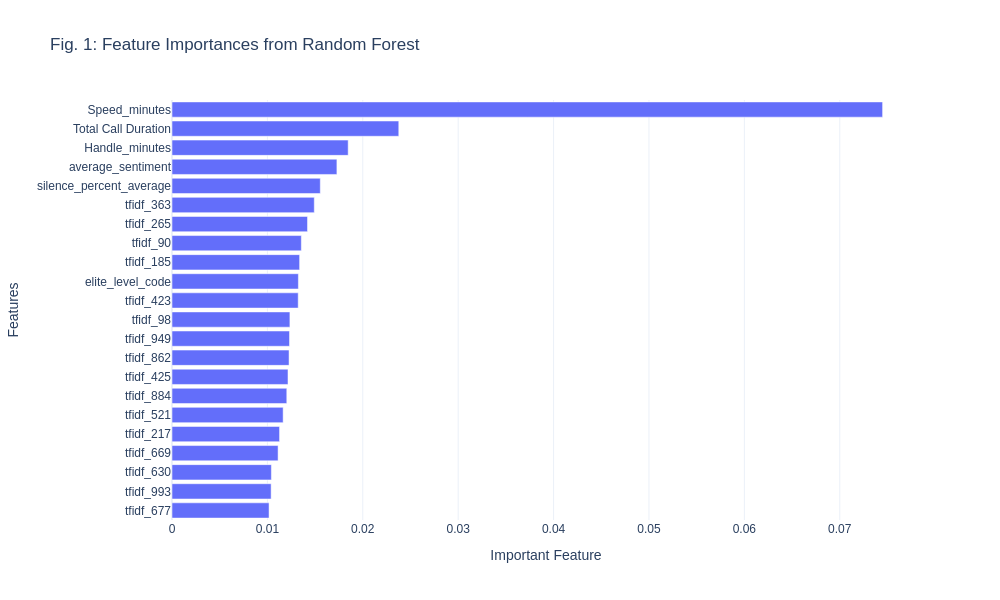

In [29]:
# IMPORTANT FEATURES BASED ON RANDOM FOREST
important_feature = rf_model.feature_importances_

# Create a DataFrame of feature importances
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'Important Feature': important_feature
}).sort_values(by='Important Feature', ascending=True).reset_index(drop = True)

# Thresold = 0.01
# Slice those features whose importance is greater than 0.1
imp_feat = feature_importance_df[feature_importance_df['Important Feature'] > 0.01]
# Names of important features
imp_feat_name = imp_feat['feature'].values
print("Following are Important Features:")
print(imp_feat_name)

# Graph
# Create a bar chart using Plotly
fig = px.bar(
    imp_feat,
    x='Important Feature',
    y='feature',
    orientation='h',
    title='Fig. 1: Feature Importances from Random Forest',
    labels={'importance': 'Importance', 'feature': 'Features'},
    template='plotly_white'
)

fig.update_layout(width=1000, height=600)
# Show the plot
fig.show()

### APPLYING THE ABOVE FEATURES & MODEL AGAIN

In [13]:
X_imp = X[imp_feat_name]

# SPLITTING INTO TRAINING & VALIDATION SET
# Step 3: Split the data into training and testing sets
X_imp_train, X_imp_val, Y_imp_train, Y_imp_val = train_test_split(X_imp, Y, test_size=0.2, random_state=42)


# LOGISTIC MODEL
logreg_model1 = LogisticRegression(max_iter=200)
# Train the model
logreg_model1.fit(X_imp_train, Y_imp_train)
# Evaluate the model on the Validation set
Y_imp_pred = logreg_model1.predict(X_imp_val)
# Print accuracy and classification report
print("Logistic Regression Accuracy:", accuracy_score(Y_imp_val, Y_imp_pred))
#print("Logistic Regression Classification Report:\n", classification_report(Y_imp_val, Y_imp_pred))



# RANDOM FOREST
rf_model1 = RandomForestClassifier(n_estimators=100, random_state=42)
# Train RandomForest model
rf_model1.fit(X_imp_train, Y_imp_train)
# Evaluate RandomForest model
Y_imp_pred_rf = rf_model1.predict(X_imp_val)
# Print accuracy and classification report for RandomForest
print("RandomForest Accuracy:", accuracy_score(Y_imp_val, Y_imp_pred_rf))
#print("RandomForest Classification Report:\n", classification_report(Y_imp_val, Y_imp_pred_rf))


Logistic Regression Accuracy: 0.34341009676693424
RandomForest Accuracy: 0.41189708198934816


# 2. PREPARING TEST DATASET

In [14]:
# CALLING THE TEST DATASET
test_df = pd.read_csv("/content/drive/MyDrive/Colab Datasets/United Airlines Dataset/test.csv")
test_df.shape

(5157, 1)

In [15]:
# MERGING THE TEST DATASET
# Merging test dataset with calls dataset
test_merged = pd.merge(test_df, calls, on='call_id', how='left')

# Merging customer dataset to test file
test_merged = pd.merge(test_merged , customers, on='customer_id', how='left')

# Merging Sentiment Statistic with test file
test_merged = pd.merge(test_merged , sent_stat, on='call_id', how='left')
test_merged.shape

(5157, 14)

In [16]:
# CHECKING MISSING VALUES
test_merged.isnull().sum()

,0
call_id,0
customer_id,0
agent_id_x,0
call_start_datetime,0
agent_assigned_datetime,0
call_end_datetime,0
call_transcript,0
customer_name,0
elite_level_code,1808
agent_id_y,0


In [17]:
# DATA CLEANING - 1
# HANDLING MISSING VALUES

# Handling Missing Values of elite level code by assigning them with 0
test_merged['elite_level_code'].fillna(0, inplace = True)

# Handling missing values in agent_tone (categorical)
# Impute missing values with a new category "Unknown"
test_merged['agent_tone'].fillna('Unknown', inplace=True)

# Handling missing values in average_sentiment (numerical)
# Impute missing values with the median
test_merged['average_sentiment'].fillna(test_merged['average_sentiment'].median(), inplace=True)

print(test_merged.isnull().sum())

call_id                    0
customer_id                0
agent_id_x                 0
call_start_datetime        0
agent_assigned_datetime    0
call_end_datetime          0
call_transcript            0
customer_name              0
elite_level_code           0
agent_id_y                 0
agent_tone                 0
customer_tone              0
average_sentiment          0
silence_percent_average    0
dtype: int64


In [18]:
# DATA CLEANING - 3
# Agent_id is being repeated in test dataset so make it one column
test_merged = test_merged.drop('agent_id_y', axis=1)
test_merged.rename(columns={'agent_id_x': 'agent_id'}, inplace=True)

In [19]:
# FEATURE ENGINEERING - 1
# CREATING AHT & AST

# Conversion to datetime datatypes
test_merged["call_start_datetime"] = pd.to_datetime(test_merged["call_start_datetime"])
test_merged["agent_assigned_datetime"] = pd.to_datetime(test_merged["agent_assigned_datetime"])
test_merged["call_end_datetime"] = pd.to_datetime(test_merged["call_end_datetime"])

# Metric
# Speed to answer
test_merged["Speed"] = test_merged["agent_assigned_datetime"]-test_merged["call_start_datetime"]
# Handling time
test_merged["Handle"] = test_merged["call_end_datetime"]-test_merged["agent_assigned_datetime"]
# Total Call Duration
test_merged["Total Call Duration"] = test_merged["call_end_datetime"]-test_merged["call_start_datetime"]

# Use seconds as measure
test_merged["Speed_seconds"] = test_merged["Speed"].dt.total_seconds()
test_merged["Handle_seconds"] = test_merged["Handle"].dt.total_seconds()

# Using minutes as measure
test_merged["Speed_minutes"] = test_merged["Speed"].dt.total_seconds() / 60
test_merged["Handle_minutes"] = test_merged["Handle"].dt.total_seconds() / 60
test_merged["Total Call Duration"] = test_merged["Total Call Duration"].dt.total_seconds() / 60

test_merged.head(3)

,call_id,customer_id,agent_id,call_start_datetime,agent_assigned_datetime,call_end_datetime,call_transcript,customer_name,elite_level_code,agent_tone,customer_tone,average_sentiment,silence_percent_average,Speed,Handle,Total Call Duration,Speed_seconds,Handle_seconds,Speed_minutes,Handle_minutes
0,7732610078,4029953261,488324,2024-08-01 00:23:00,2024-08-01 00:34:00,2024-08-01 01:32:00,\n\nAgent: Thank you for calling United Airlin...,Cassandra Flores,0.0,neutral,neutral,-0.06,0.58,0 days 00:11:00,0 days 00:58:00,69.0,660.0,3480.0,11.0,58.0
1,2400299738,2034858976,963118,2024-08-01 01:33:00,2024-08-01 01:41:00,2024-08-01 01:54:00,\n\nAgent: Thank you for calling United Airlin...,Hannah Drake,0.0,calm,angry,0.01,0.40,0 days 00:08:00,0 days 00:13:00,21.0,480.0,780.0,8.0,13.0
2,6533095063,1874845993,519057,2024-08-01 02:17:00,2024-08-01 02:27:00,2024-08-01 02:29:00,\n\nAgent: Thank you for calling United Airlin...,Larry Nolan,0.0,neutral,calm,0.00,0.49,0 days 00:10:00,0 days 00:02:00,12.0,600.0,120.0,10.0,2.0


In [20]:
# FEATURE ENGINEERING - 2
# CONVERTING CALL TRANSCRIPT INTO MACHINE READBLE DATA USING NLP, TF-IDF PROCESSING.

# Package Calling
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Reduce the size of the transcripts by truncating & Proceed with TF-IDF processing.
# Limit the size of call transcripts to reduce memory consumption (e.g., first 500 characters of each transcript)
test_merged['call_transcript'] = test_merged['call_transcript'].str.slice(0, 500)

# Re-split the data after truncation
X_test_text = test_merged['call_transcript']

# Apply TF-IDF Vectorization to the text data (to convert text into numeric features)
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X_test_tfidf = tfidf_vectorizer.fit_transform(X_test_text)

# Conver the sparse matrix to DataFrame
tfidf_test_df = pd.DataFrame(X_test_tfidf.toarray(), columns=[f'tfidf_{i}' for i in range(X_test_tfidf.shape[1])])

In [21]:
# MAKING FINAL DATASET IN WHICH, WILL PREDICT USING OUR MODEL
# DEFINING OUR NUMERICAL & CATEGORICAL FEATURES , RESPONSE VARIABLE(CATEGORY)
features = [ 'elite_level_code', 'Handle_minutes', 'Speed_minutes',  'Total Call Duration' ,'silence_percent_average', 'average_sentiment','agent_tone',  'customer_tone']

# SLICING DATASET BASED ON FEATURES & RESPONSE
X_test = test_merged[features]
# COMBINING THE 'TFIDF FEATURES' i.e., tfidf_df with X
X_test = pd.concat([X_test.reset_index(drop=True), tfidf_test_df.reset_index(drop=True)], axis=1)


In [22]:
# ENCODING THE CATEGORICAL FEATURES
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# EXTRACT CATEGORICAL FEATURES
categorical_feature = [feature for feature in X_test.columns if X_test[feature].dtypes == 'object']

# MAPPING THE FEATURES
for feature in categorical_feature:
    X_test[feature] = le.fit_transform(X_test[feature])
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print(le_name_mapping)

{'Unknown': 0, 'angry': 1, 'calm': 2, 'frustrated': 3, 'neutral': 4, 'polite': 5}
{'angry': 0, 'calm': 1, 'frustrated': 2, 'neutral': 3, 'polite': 4}


In [23]:
# CONSIDER THE IMPORTANT FEATURES WHICH WE FOUND DURING OUR TRAINING
X_test = X_test[imp_feat_name]
X_test.head(3)

,tfidf_677,tfidf_993,tfidf_630,tfidf_669,tfidf_217,tfidf_521,tfidf_884,tfidf_425,tfidf_862,tfidf_949,...,elite_level_code,tfidf_185,tfidf_90,tfidf_265,tfidf_363,silence_percent_average,average_sentiment,Handle_minutes,Total Call Duration,Speed_minutes
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.58,-0.06,58.0,69.0,11.0
1,0.0,0.069368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.254888,...,0.0,0.0,0.0,0.0,0.0,0.40,0.01,13.0,21.0,8.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.49,0.00,2.0,12.0,10.0


In [24]:
# APPLYING OUR PRE-TRAINED MODEL IN TEST DATA

# Predict using RandomForest
test_predictions = rf_model1.predict(X_test)

# Prepare submission file
submission_df = test_merged[['call_id']].copy()
submission_df['primary_call_reason'] = test_predictions

# Save the submission file
submission_df.to_csv('test.csv', index=False)
print("Submission file created: 'test.csv'")


Submission file created: 'test.csv'
